In [1]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
pd.set_option('mode.chained_assignment',  None) #because of Error Message
import seaborn as sns
import datetime

train=pd.read_csv('https://drive.google.com/uc?export=download&id=1KA7mKUmQv4PrF-qMFrH35LN6q_i56Bf1', dtype={'StateHoliday':'str'})
store=pd.read_csv('https://drive.google.com/uc?export=download&id=1_o04Vnqzo3v-MTk20MF3OMw2QFz0Fbo0')
train = train.merge(store, on=['Store'])

In [2]:
train.drop(train[train['Open']==0].index,inplace=True)

In [3]:
train.reset_index(drop=True,inplace=True)

def find_outlier(data):
    Q1 , Q3 = np.percentile(data,[25,75])
    IQR = Q3 - Q1
    Over_outlier = Q3 + 1.5*IQR
    Low_outlier = Q1 - 1.5*IQR
    location = np.where((data>Over_outlier)|(data<Low_outlier))
    result = [location[0],len(location[0])]
    return result

locationOfOutlier  =find_outlier(train['Sales'])[0]
numOfOutlier = find_outlier(train['Sales'])[1]

print("Number of Outlier is " , numOfOutlier)
print("percentage of Outlier of whole data ", (numOfOutlier/len(train))*100,"%")

train.drop(index = locationOfOutlier,inplace = True)

Number of Outlier is  30769
percentage of Outlier of whole data  3.6439236752598316 %


In [4]:
train = train.fillna(0)
train['StateHoliday'].value_counts(),train['SchoolHoliday'].value_counts()

(0    812866
 a       591
 b       108
 c        58
 Name: StateHoliday, dtype: int64,
 0    657162
 1    156461
 Name: SchoolHoliday, dtype: int64)

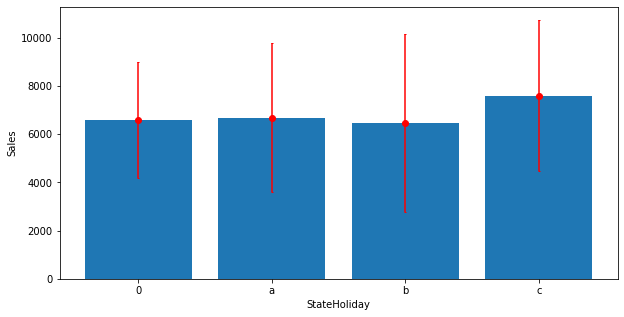

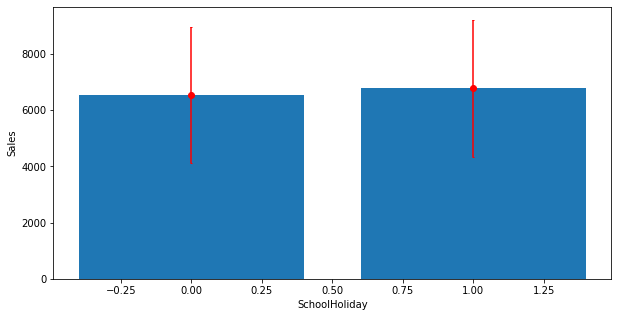

In [5]:
catvar = ['StateHoliday','SchoolHoliday']

for i in catvar:
    sale_mean = train.groupby(i)['Sales'].mean()
    sale_std = train.groupby(i)['Sales'].std()
    plt.figure(figsize=(10,5))
    plt.xlabel(i)
    plt.ylabel('Sales')
    plt.bar(range(len(sale_mean)),sale_mean)
    plt.errorbar(sale_mean.index,sale_mean,yerr=sale_std, fmt='o', c='r',ecolor='r',capthick=1,capsize=1)

In [6]:
train['Date'] = pd.to_datetime(train['Date'])
train['Year'] =train['Date'].dt.year
train['Month']=train['Date'].dt.month

pred_train = train[['Date','Sales','Store']]
pred_train = pred_train.rename(columns = {'Sales':'After1WeekSales'})
pred_train['Date'] = train['Date'] + datetime.timedelta(days=7)
pred_train = train.merge(pred_train,on=['Store','Date'],how='left')
pred_train = pred_train.dropna(subset =['After1WeekSales'])

pred_train

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,After1WeekSales
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,3706.0
1,1,4,2015-07-30,5020,546,1,1,0,1,c,...,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,3769.0
2,1,3,2015-07-29,4782,523,1,1,0,1,c,...,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,3464.0
3,1,2,2015-07-28,5011,560,1,1,0,1,c,...,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,3558.0
4,1,1,2015-07-27,6102,612,1,1,0,1,c,...,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,4395.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813612,1115,1,2013-01-14,3158,252,1,0,0,0,d,...,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",2013,1,6905.0
813613,1115,6,2013-01-12,4497,350,1,0,0,0,d,...,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",2013,1,4771.0
813614,1115,5,2013-01-11,5142,351,1,1,0,1,d,...,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",2013,1,4540.0
813615,1115,4,2013-01-10,5007,339,1,1,0,1,d,...,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",2013,1,4297.0


# Get new variable from CompetitionDistance

In [7]:
#get new variable from CompetitionDistance
store = store.sort_values('Store')
mean_sales = train.groupby(['Store'])['Sales'].mean()
new_store = store.merge(mean_sales,on='Store')
new_store.rename(columns = {'Sales' :'Mean_Sales'},inplace=True)
new_store = new_store.dropna(subset=['CompetitionDistance'],axis=0)

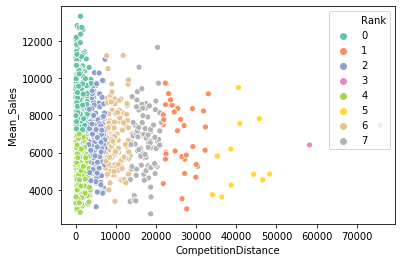

In [8]:
from sklearn.cluster import KMeans
rank_store = new_store[['Store','CompetitionDistance','Mean_Sales']]
kmeans = KMeans(n_clusters=8)
kmeans.fit(rank_store[['CompetitionDistance','Mean_Sales']])

rank_store['Rank'] = kmeans.labels_

sns.scatterplot(x="CompetitionDistance", y="Mean_Sales", hue="Rank",
                data=rank_store[['CompetitionDistance','Mean_Sales','Rank']] ,palette="Set2")

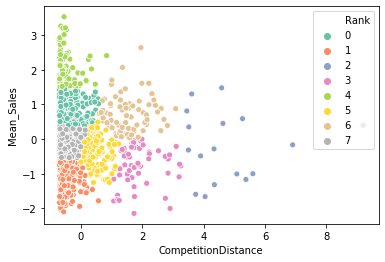

In [9]:
std_kmeans = KMeans(n_clusters=8)

std_rank_store = new_store[['Store','CompetitionDistance','Mean_Sales']]
std_rank_store['CompetitionDistance'] = (std_rank_store['CompetitionDistance']-std_rank_store['CompetitionDistance'].mean())/std_rank_store['CompetitionDistance'].std()
std_rank_store['Mean_Sales'] = (std_rank_store['Mean_Sales']-std_rank_store['Mean_Sales'].mean())/std_rank_store['Mean_Sales'].std()
std_kmeans.fit(std_rank_store[['CompetitionDistance','Mean_Sales']])

std_rank_store['Rank'] = std_kmeans.labels_
sns.scatterplot(x="CompetitionDistance", y="Mean_Sales", hue="Rank", 
                data=std_rank_store[['CompetitionDistance','Mean_Sales','Rank']] , palette="Set2");

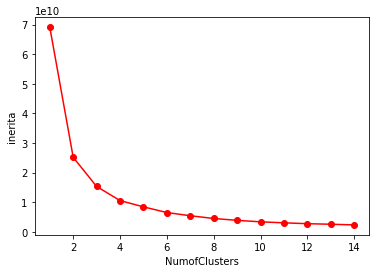

Text(0.5, 0, 'NumofClusters')

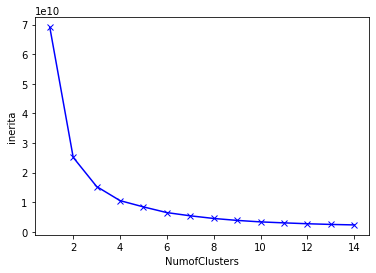

In [10]:
inerita = []
std_inerita = []
for i in range(1,15):
    kmeans.n_clusters = i
    kmeans.fit(new_store[['CompetitionDistance','Mean_Sales']])
    std_kmeans.n_clusters = i
    std_kmeans.fit(new_store[['CompetitionDistance','Mean_Sales']])
    inerita.append(kmeans.inertia_)
    std_inerita.append(std_kmeans.inertia_)
    #ertia means variance in each cluster
    
plt.plot(range(1,15),inerita,color='red',marker = 'o')
plt.ylabel("inerita")
plt.xlabel("NumofClusters")
plt.show()
plt.plot(range(1,15),std_inerita,color='blue', marker = 'x')
plt.ylabel("inerita")
plt.xlabel("NumofClusters")

In [11]:
#for not standardizationed CompetitionDistance Rank System
rank_train = pred_train[['Date','Store','After1WeekSales']]
rank_train = rank_train.merge(rank_store[['Rank','Store']],on='Store',how='left')
rank_train = rank_train.dropna(subset=['Rank'])
rank_train = rank_train.astype({'Rank':'int'})

#for standardizationed CompeitionDistance Rank System
std_rank_train = pred_train[['Date','Store','After1WeekSales']]
std_rank_train = std_rank_train.merge(std_rank_store[['Rank','Store']],on='Store',how='left')
std_rank_train = std_rank_train.dropna(subset=['Rank'])
std_rank_train = std_rank_train.astype({'Rank':'int'})

<ErrorbarContainer object of 3 artists>

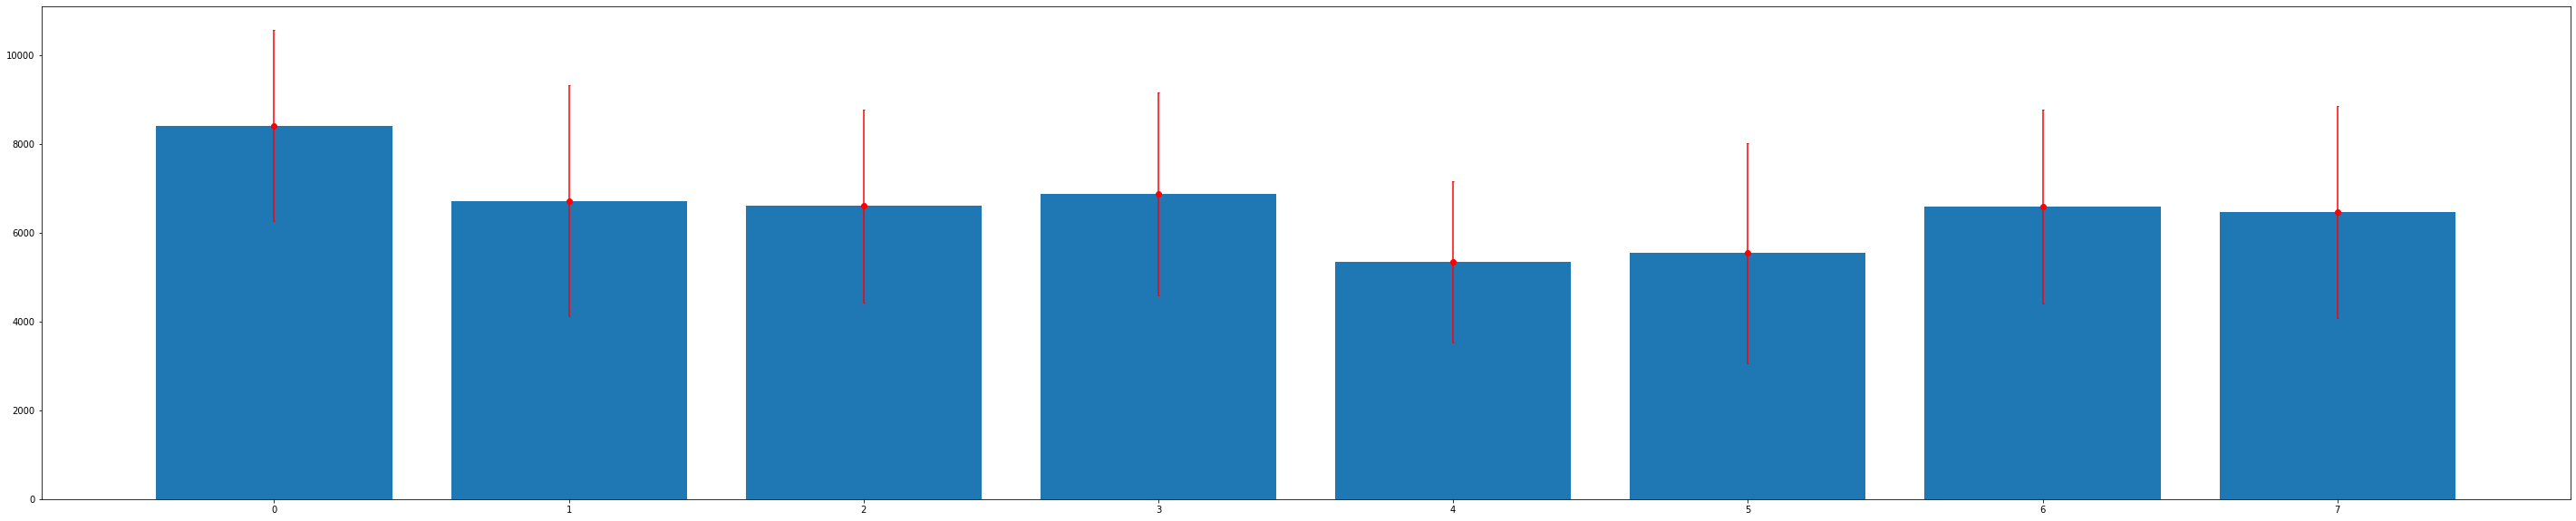

In [12]:
A = rank_train.groupby(['Rank'])['After1WeekSales'].mean()
B = rank_train.groupby(['Rank'])['After1WeekSales'].std()
plt.figure(figsize=(50,10))
plt.bar(range(len(A)),A)
plt.errorbar(range(len(A)),A,yerr=B, fmt='o', c='r',ecolor='r',capthick=1,capsize=1)

<ErrorbarContainer object of 3 artists>

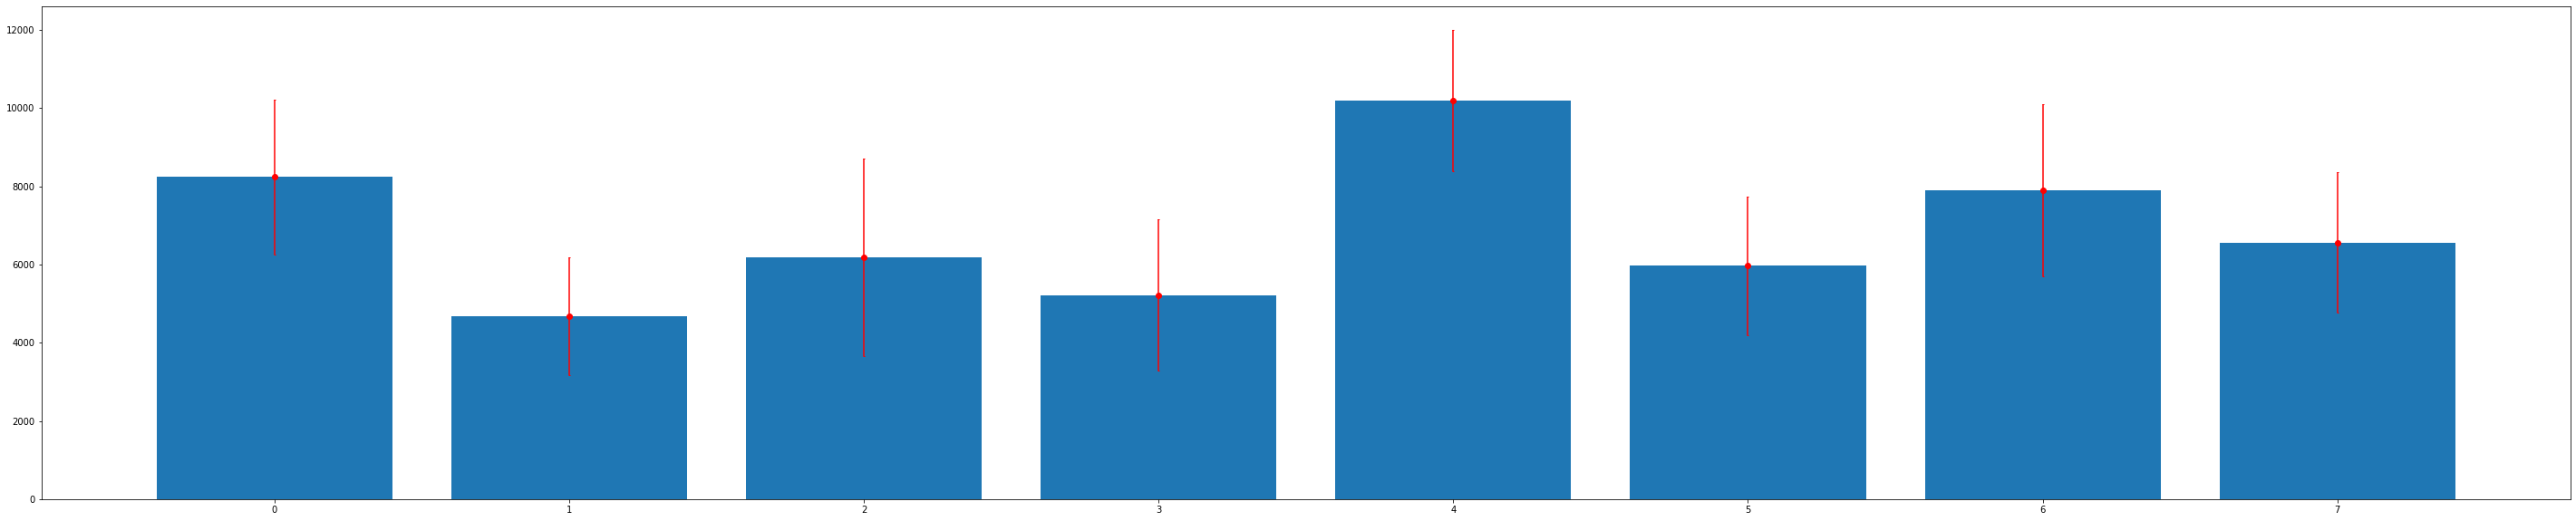

In [13]:
A = std_rank_train.groupby(['Rank'])['After1WeekSales'].mean()
B = std_rank_train.groupby(['Rank'])['After1WeekSales'].std()
plt.figure(figsize=(50,10))
plt.bar(range(len(A)),A)
plt.errorbar(range(len(A)),A,yerr=B, fmt='o', c='r',ecolor='r',capthick=1,capsize=1)

# Get new variables from Promo2 and Promo2interval

In [14]:
promo_store = new_store[['Store','Promo2','PromoInterval','Promo2SinceWeek','Promo2SinceYear']]
promo_store = promo_store.astype({'PromoInterval':'string'})
promo_store.dropna(subset=['PromoInterval'],axis=0,inplace=True)
promo_store.reset_index(drop = True , inplace=True)

In [15]:
import datetime

promo_store['PromoInterval'].value_counts()
promo_store['Start1stPromo'],promo_store['Start2ndPromo'],promo_store['Start3rdPromo'],promo_store['Start4thPromo'] = "a","a","a","a"

MonthToNum = {'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sept':9,'Oct':10,'Nov':11,'Dec':12}

for i in range(len(promo_store['PromoInterval'])):
    list  = promo_store['PromoInterval'][i].split(",")
    promo_store['Start1stPromo'][i] = MonthToNum[list[0]]
    promo_store['Start2ndPromo'][i] = MonthToNum[list[1]]
    promo_store['Start3rdPromo'][i] = MonthToNum[list[2]]
    promo_store['Start4thPromo'][i] = MonthToNum[list[3]]

#promo2_start_Date필요 
promo_store = promo_store.astype({'Promo2SinceYear':'int','Promo2SinceWeek':'int'})
promo_store['Promo2StartDate'] = 0
promo_store['Promo2StartDate'] = pd.to_datetime(promo_store['Promo2StartDate'])

for i in range(len(promo_store['Promo2SinceYear'])):
    promo_store['Promo2StartDate'][i] = datetime.date(promo_store['Promo2SinceYear'][i], 1,1) + datetime.timedelta(
        days = 7*int(promo_store['Promo2SinceWeek'][i]))

promo_store =promo_store.drop(columns = ['Promo2SinceWeek','Promo2SinceYear','PromoInterval','Promo2'])

In [16]:
promo_store

,Store,Start1stPromo,Start2ndPromo,Start3rdPromo,Start4thPromo,Promo2StartDate
0,2,1,4,7,10,2010-04-02
1,3,1,4,7,10,2011-04-09
2,11,1,4,7,10,2012-01-08
3,12,1,4,7,10,2010-04-02
4,13,2,5,8,11,2009-11-12
...,...,...,...,...,...,...
565,1106,1,4,7,10,2013-08-06
566,1107,1,4,7,10,2010-04-02
567,1109,1,4,7,10,2012-06-03
568,1111,1,4,7,10,2013-08-06


In [17]:
sales = pred_train[['Store','Date','Sales','Year','Month','After1WeekSales']]
sales = pd.merge(sales, promo_store, on='Store',how='outer')

sales['Date'] =pd.to_datetime(sales['Date'])
sales['Promo2StartDate'] =pd.to_datetime(sales['Promo2StartDate'])

sales['AfterPromo2Sales'] = sales.apply(lambda x : x['Sales']
                                     if (x['Date']>=x['Promo2StartDate'])
                                     else 0,axis=1)
sales=sales.sort_values('Date')

In [18]:
#확인하기위해서 promo2가 매출에 영향을 끼치는지 안끼치는지 그리고 Promo시작 월에 하는지안하는지ㅁ
before_sales = sales.drop(sales[sales['AfterPromo2Sales']!=0].index)
after_sales = sales.drop(sales[sales['AfterPromo2Sales']==0].index)

before_sales['Date'] = pd.to_datetime(before_sales['Date'])
after_sales['Date'] = pd.to_datetime(after_sales['Date'])

# before_sales.index = before_sales['Date']
# after_sales.index = after_sales['Date']

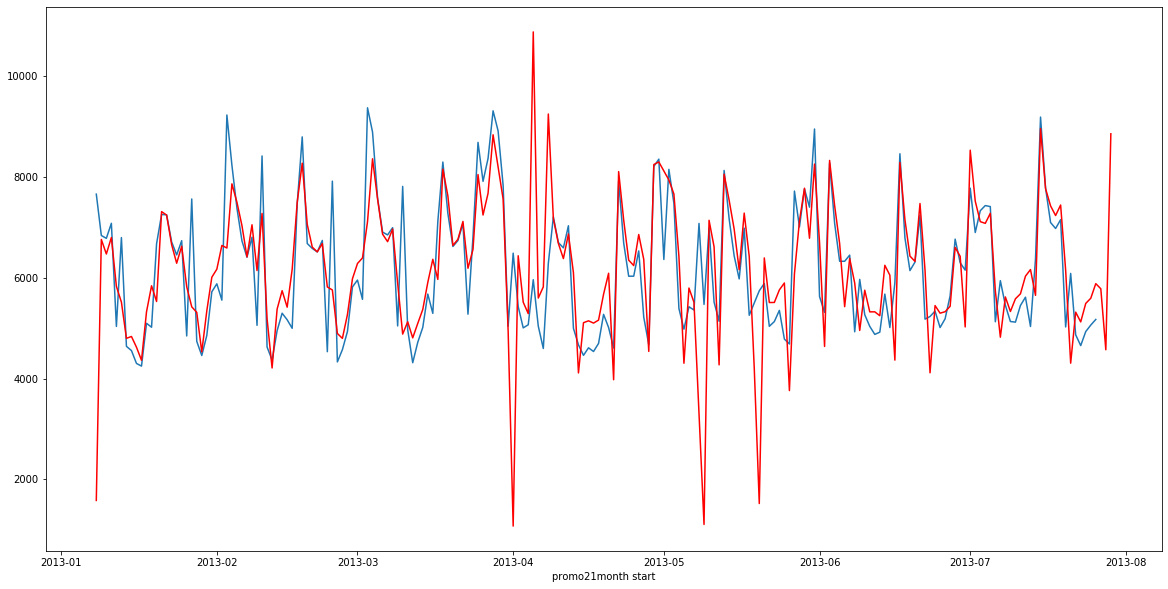

6172.325888363634 6166.823028778991


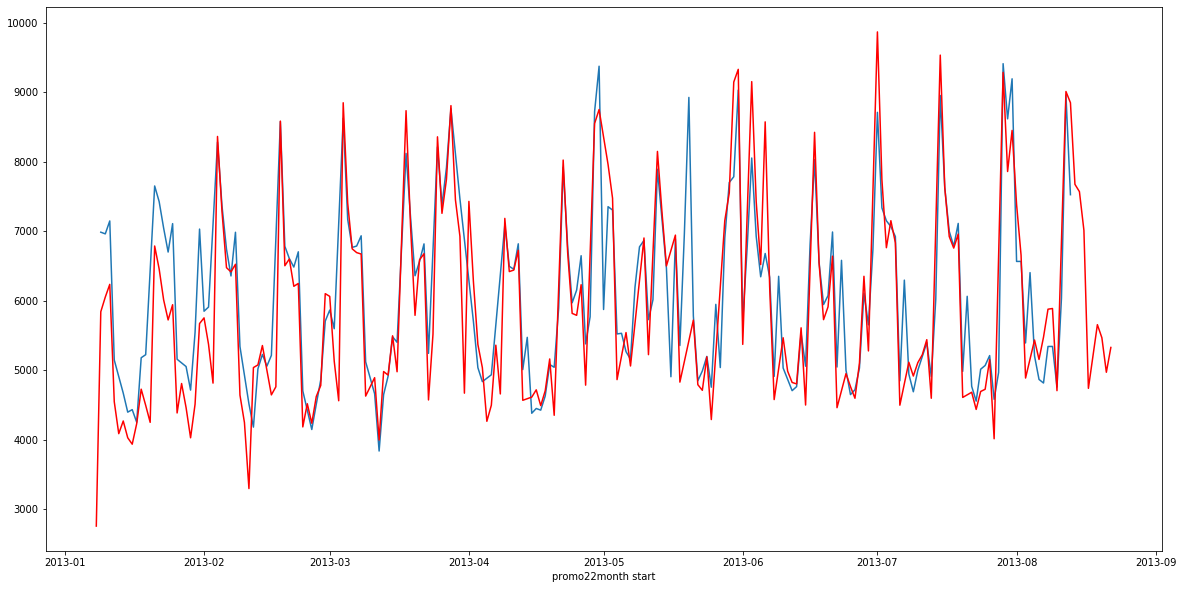

6109.451658474074 5906.765107829039


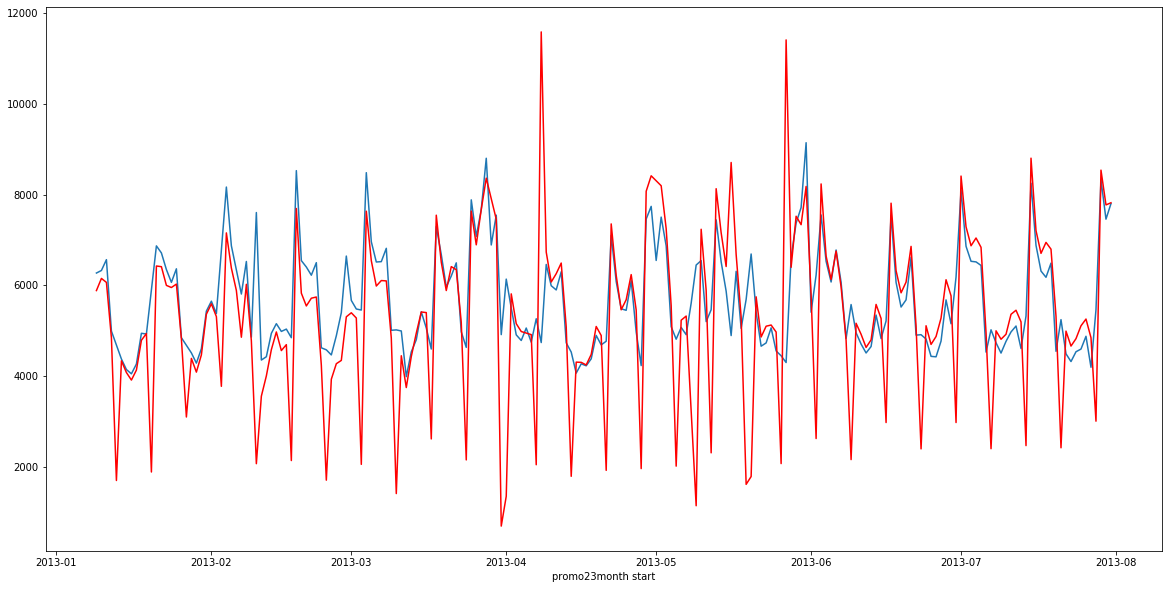

5692.443800516877 5291.9139086019295


In [19]:
#for testing sales data which have each samples classfied by PromoInterval
for i in range(1,4):
    test1_sales = after_sales[after_sales['Start1stPromo']==i]
    test2_sales = before_sales[before_sales['Start1stPromo']==i]
    fig = plt.figure(figsize=(20,10))
    A = test1_sales.groupby(['Date'])['Sales'].mean().head(200)
    B = test2_sales.groupby(['Date'])['Sales'].mean().head(200)
    plt.plot(A.index,A)
    plt.plot(B.index,B,color = 'r')
    plt.xlabel("promo2"+str(i)+"month start")
    plt.show()
    print(A.mean(),B.mean())

In [20]:
#for compare each store that have promo2 starttime in data's date period(2013.1.1~2015.7)
import random

starttime = datetime.datetime(2013,1,1)
testing_promo2 = sales[sales['Promo2StartDate']>starttime][['Store','Date','Sales','Promo2StartDate','Start1stPromo']]
testing_promo2 = testing_promo2.sort_values(['Store','Date'])
testing_promo2.index = testing_promo2['Date']

store_num = testing_promo2['Store'].unique()

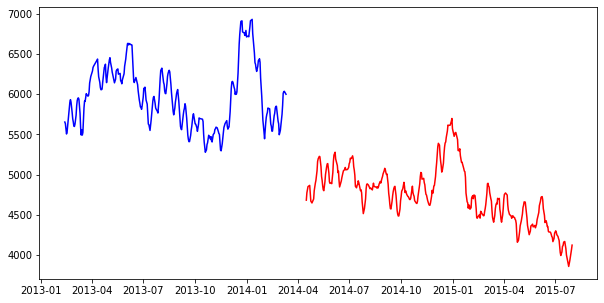

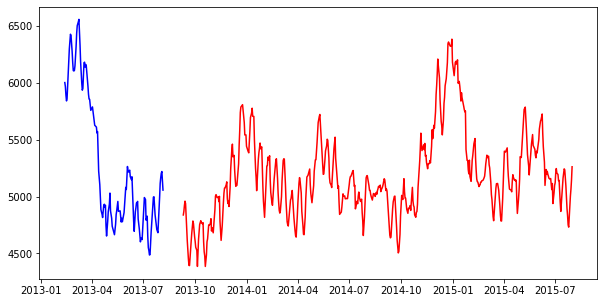

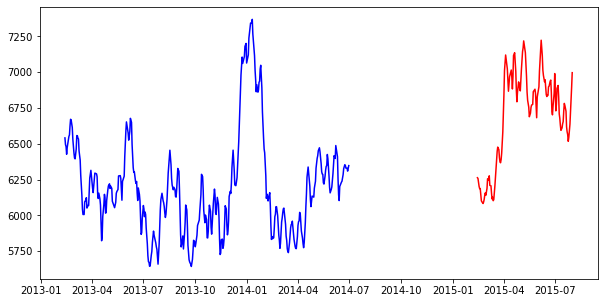

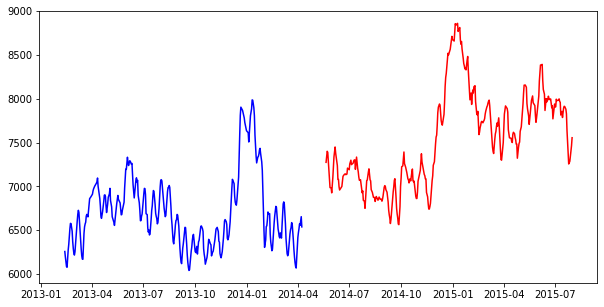

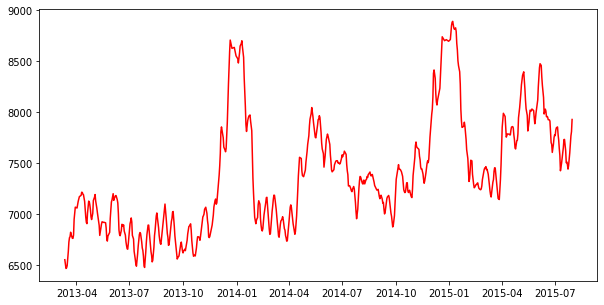

In [21]:
select_random = random.sample(store_num.tolist(),5)

for i in select_random:
    test = testing_promo2[testing_promo2['Store']==i]
    before_test = test[test['Date']<test['Promo2StartDate'].values[0]]
    after_test = test[test['Date']>test['Promo2StartDate'].values[0]]
    plt.figure(figsize=(10,5))
    plt.plot(before_test.index,before_test['Sales'].rolling(30).mean(),color ='b')
    plt.plot(after_test.index,after_test['Sales'].rolling(30).mean(),color ='r')

In [22]:
after_test
test2_sales

,Store,Date,Sales,Year,Month,After1WeekSales,Start1stPromo,Start2ndPromo,Start3rdPromo,Start4thPromo,Promo2StartDate,AfterPromo2Sales
580206,851,2013-01-09,4632,2013,1,4959.0,3,6,9,12,2014-12-10,0
430500,629,2013-01-09,7842,2013,1,7774.0,3,6,9,12,2015-06-11,0
231915,334,2013-01-09,5849,2013,1,5165.0,3,6,9,12,2013-05-07,0
222269,321,2013-01-09,6820,2013,1,4868.0,3,6,9,12,2014-03-12,0
84999,121,2013-01-09,5056,2013,1,4831.0,3,6,9,12,2013-09-10,0
...,...,...,...,...,...,...,...,...,...,...,...,...
594938,872,2015-06-09,7692,2015,6,10292.0,3,6,9,12,2015-06-11,0
429969,629,2015-06-09,5573,2015,6,7914.0,3,6,9,12,2015-06-11,0
429968,629,2015-06-10,5814,2015,6,7378.0,3,6,9,12,2015-06-11,0
594937,872,2015-06-10,6785,2015,6,10931.0,3,6,9,12,2015-06-11,0


In [23]:
# make promo2 column on sales data, 
print(store[store['Promo2']==0].isnull().sum())
print(len(store[store['Promo2']==0]))

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            2
CompetitionOpenSinceMonth    148
CompetitionOpenSinceYear     148
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64
544


In [24]:
sales['Promo2'] = 0

sales.loc[(sales['Promo2StartDate'].notnull()) & (sales['Date']>sales['Promo2StartDate']),'Promo2'] = 1
sales = sales.sort_values(['Store','Date'])
sales

,Store,Date,Sales,Year,Month,After1WeekSales,Start1stPromo,Start2ndPromo,Start3rdPromo,Start4thPromo,Promo2StartDate,AfterPromo2Sales,Promo2
750,1,2013-01-09,5471,2013,1,5530.0,NaN,NaN,NaN,NaN,NaT,0,0
749,1,2013-01-10,4892,2013,1,4327.0,NaN,NaN,NaN,NaN,NaT,0,0
748,1,2013-01-11,4881,2013,1,4486.0,NaN,NaN,NaN,NaN,NaT,0,0
747,1,2013-01-12,4952,2013,1,4997.0,NaN,NaN,NaN,NaN,NaT,0,0
746,1,2013-01-14,4717,2013,1,7176.0,NaN,NaN,NaN,NaN,NaT,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
763452,1115,2015-07-27,10712,2015,7,6083.0,3,6,9,12,2012-06-03,10712,1
763451,1115,2015-07-28,8093,2015,7,5074.0,3,6,9,12,2012-06-03,8093,1
763450,1115,2015-07-29,7661,2015,7,5342.0,3,6,9,12,2012-06-03,7661,1
763449,1115,2015-07-30,8405,2015,7,6150.0,3,6,9,12,2012-06-03,8405,1


# Get new variable from CopmpetitionOpenSince[Year/Month]

In [25]:
#I make CompetitionPresent value 1 or 0 
#because competitionDistance only 3 null value this mean 3 store don't have competition
#below process is made for competition store made in between year 2013 to 2015 
#after CompetitionOpenDate , Competition Present value is 1 
len(store[store['CompetitionOpenSinceYear'] ==2013]),len(
    store[store['CompetitionOpenSinceYear'] ==2014]),len(
    store[store['CompetitionOpenSinceYear'] ==2015])

(83, 70, 38)

In [26]:
compete_open = store[['Store','CompetitionOpenSinceYear','CompetitionOpenSinceMonth']]
compete_open = compete_open[compete_open['CompetitionOpenSinceYear']>=2013] 
compete_open = compete_open.dropna(subset=['CompetitionOpenSinceYear'],axis=0)
compete_open.reset_index(drop=True,inplace=True)

compete_open = compete_open.astype({'CompetitionOpenSinceYear':'int','CompetitionOpenSinceMonth':'int'})
compete_open['CompetitionOpenDate'] = 0
compete_open['CompetitionOpenDate'] = pd.to_datetime(compete_open['CompetitionOpenDate'])

for i in range(len(compete_open['CompetitionOpenSinceYear'])):
         compete_open['CompetitionOpenDate'][i] = datetime.date(compete_open['CompetitionOpenSinceYear'][i],
                                                                compete_open['CompetitionOpenSinceMonth'][i],1)
sales = pd.merge(sales, compete_open[['Store','CompetitionOpenDate']], on='Store',how='outer')

In [27]:
#make CompetitionOpen column , if competetion store open value is 1, competition store not present value is 0

sales['CompetitionOpen'] = 1 
sales['CompetitionOpenDate'] = pd.to_datetime(sales['CompetitionOpenDate'])

sales.loc[(sales['CompetitionOpenDate'].notnull()) & (
    sales['Date']<sales['CompetitionOpenDate']),'CompetitionOpen'] = 0
sales

,Store,Date,Sales,Year,Month,After1WeekSales,Start1stPromo,Start2ndPromo,Start3rdPromo,Start4thPromo,Promo2StartDate,AfterPromo2Sales,Promo2,CompetitionOpenDate,CompetitionOpen
0,1,2013-01-09,5471.0,2013.0,1.0,5530.0,NaN,NaN,NaN,NaN,NaT,0.0,0.0,NaT,1
1,1,2013-01-10,4892.0,2013.0,1.0,4327.0,NaN,NaN,NaN,NaN,NaT,0.0,0.0,NaT,1
2,1,2013-01-11,4881.0,2013.0,1.0,4486.0,NaN,NaN,NaN,NaN,NaT,0.0,0.0,NaT,1
3,1,2013-01-12,4952.0,2013.0,1.0,4997.0,NaN,NaN,NaN,NaN,NaT,0.0,0.0,NaT,1
4,1,2013-01-14,4717.0,2013.0,1.0,7176.0,NaN,NaN,NaN,NaN,NaT,0.0,0.0,NaT,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
764195,1115,2015-07-28,8093.0,2015.0,7.0,5074.0,3,6,9,12,2012-06-03,8093.0,1.0,NaT,1
764196,1115,2015-07-29,7661.0,2015.0,7.0,5342.0,3,6,9,12,2012-06-03,7661.0,1.0,NaT,1
764197,1115,2015-07-30,8405.0,2015.0,7.0,6150.0,3,6,9,12,2012-06-03,8405.0,1.0,NaT,1
764198,1115,2015-07-31,8680.0,2015.0,7.0,5816.0,3,6,9,12,2012-06-03,8680.0,1.0,NaT,1


In [28]:
nullComDistance = store[store['CompetitionDistance'].isnull()]['Store'].values 
for i in nullComDistance: # NaN competitionDistance mean don't have Competition So those 3 null Store's CopmetitionOpen value 0 
    sales.loc[sales['Store']==i]['CompetitionOpen'] = 0

In [29]:
sales.drop(columns = ['Promo2StartDate','Start1stPromo','Start2ndPromo','Start3rdPromo','Start4thPromo','CompetitionOpenDate'],inplace=True)

In [30]:
sales

,Store,Date,Sales,Year,Month,After1WeekSales,AfterPromo2Sales,Promo2,CompetitionOpen
0,1,2013-01-09,5471.0,2013.0,1.0,5530.0,0.0,0.0,1
1,1,2013-01-10,4892.0,2013.0,1.0,4327.0,0.0,0.0,1
2,1,2013-01-11,4881.0,2013.0,1.0,4486.0,0.0,0.0,1
3,1,2013-01-12,4952.0,2013.0,1.0,4997.0,0.0,0.0,1
4,1,2013-01-14,4717.0,2013.0,1.0,7176.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...
764195,1115,2015-07-28,8093.0,2015.0,7.0,5074.0,8093.0,1.0,1
764196,1115,2015-07-29,7661.0,2015.0,7.0,5342.0,7661.0,1.0,1
764197,1115,2015-07-30,8405.0,2015.0,7.0,6150.0,8405.0,1.0,1
764198,1115,2015-07-31,8680.0,2015.0,7.0,5816.0,8680.0,1.0,1


# Get new variable(s) from historical sales or number of customers 

In [31]:
#making predict_customers by use moving average of customer number data
moving_average = train[['Date','Store','Customers','Sales']]
moving_average = moving_average.sort_values(['Store','Date'])
moving_average.index = moving_average['Date']

In [32]:
new_variables = moving_average.groupby('Store')['Customers'].rolling(window='7D').mean().to_frame().rename(columns={'Customers':'Customers1W'})# 7D = 7 days
new_variables['Customers2W'] = moving_average.groupby('Store')['Customers'].rolling(window='14D').mean()

new_variables['Sales1W'] = moving_average.groupby('Store')['Sales'].rolling(window='7D').mean()
new_variables['Sales2W'] = moving_average.groupby('Store')['Sales'].rolling(window='14D').mean()

new_variables=new_variables.reset_index()

new_variables['Date']=new_variables['Date']+pd.to_timedelta('7D')

new_variables.head()

,Store,Date,Customers1W,Customers2W,Sales1W,Sales2W
0,1,2013-01-09,668.000000,668.000000,5530.0,5530.0
1,1,2013-01-10,623.000000,623.000000,4928.5,4928.5
2,1,2013-01-11,621.666667,621.666667,4781.0,4781.0
3,1,2013-01-12,625.000000,625.000000,4835.0,4835.0
4,1,2013-01-14,657.000000,657.000000,5303.2,5303.2


In [33]:
sales = sales.merge(new_variables,on = ['Store','Date'])

In [34]:
#max moving average 14D ,and starting day is 2013-01-01 So 14 interval days not accurate movingaverage data
sales = sales[sales['Date']>=pd.to_datetime('2013-01-15')]
sales.drop(columns = ['Month','Year','Sales'],inplace = True)
sales = sales.merge(train[['Promo','StoreType','Assortment','DayOfWeek','Date','Store']],on=['Date','Store'])

In [35]:
sales
sales.dtypes

Store                        int64
Date                datetime64[ns]
After1WeekSales            float64
AfterPromo2Sales           float64
Promo2                     float64
CompetitionOpen              int64
Customers1W                float64
Customers2W                float64
Sales1W                    float64
Sales2W                    float64
Promo                        int64
StoreType                   object
Assortment                  object
DayOfWeek                    int64
dtype: object

# Modeling

In [36]:
catvar = ['StoreType','Assortment','DayOfWeek']
for c in catvar:
    temp =pd.get_dummies(sales[c],prefix=c,drop_first=True)
    sales=pd.concat((sales,temp),axis=1)
sales.drop(columns = catvar+['Store'], inplace =True)


In [37]:
linear = LinearRegression()
ridge = Ridge()
lasso = Lasso()

train_set = sales[sales['Date']<=pd.to_datetime('20141231')]
val_set = sales[sales['Date']>pd.to_datetime('20141231')]
train_set.drop(columns=['Date'],inplace=True)
val_set.drop(columns=['Date'],inplace=True)


In [38]:
trainX = train_set.drop(columns = ['After1WeekSales'])
trainy = train_set['After1WeekSales']

valX = val_set.drop(columns = ['After1WeekSales'])
valy = val_set['After1WeekSales']


In [39]:
linear.fit(trainX,trainy)
linear.score(valX,valy)

0.7074781879005773

In [40]:
train_set

,After1WeekSales,AfterPromo2Sales,Promo2,CompetitionOpen,Customers1W,Customers2W,Sales1W,Sales2W,Promo,StoreType_b,StoreType_c,StoreType_d,Assortment_b,Assortment_c,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
0,5580.0,0.0,0.0,1,656.500000,656.500000,5349.333333,5349.333333,0,0,1,0,0,0,1,0,0,0,0,0
1,5471.0,0.0,0.0,1,649.500000,652.142857,5339.500000,5366.714286,0,0,1,0,0,0,0,1,0,0,0,0
2,4892.0,0.0,0.0,1,655.666667,647.500000,5433.666667,5307.375000,0,0,1,0,0,0,0,0,1,0,0,0
3,4881.0,0.0,0.0,1,651.166667,641.333333,5499.500000,5260.000000,0,0,1,0,0,0,0,0,0,1,0,0
4,4952.0,0.0,0.0,1,653.000000,641.800000,5492.000000,5229.200000,0,0,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758708,9269.0,5603.0,1.0,1,538.500000,520.083333,8683.833333,8243.750000,0,0,0,1,0,1,0,1,0,0,0,0
758709,10898.0,6990.0,1.0,1,639.000000,532.250000,10962.333333,8559.833333,0,0,0,1,0,1,0,0,0,0,1,0
758710,11361.0,7167.0,1.0,1,647.500000,559.916667,10774.000000,8990.333333,0,0,0,1,0,1,0,0,0,0,0,0
758711,12214.0,7148.0,1.0,1,683.166667,596.750000,10936.666667,9519.833333,0,0,0,1,0,1,1,0,0,0,0,0


In [41]:
#for scaling problem present in Lasso And Ridge model, we should standardization data for Regression in Ridge and LAsso
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()   

std_trainX = scaler.fit(trainX).transform(trainX)
std_trainy = (trainy - trainy.mean())/trainy.std()


std_valX = scaler.fit(valX).transform(valX)
std_valy = (valy - valy.mean())/valy.std()

In [42]:
alphas = np.logspace(-3,3,30)

result = pd.DataFrame(index=alphas,columns=['Ridge','Lasso'])

for alpha in alphas:
    ridge.alpha = alpha
    lasso.alpha = alpha
    ridge.fit(std_trainX,std_trainy)
    result.loc[alpha,'Ridge'] =ridge.score(std_valX,std_valy)
    lasso.fit(std_trainX,std_trainy)
    result.loc[alpha,'Lasso'] =lasso.score(std_valX,std_valy)

In [43]:
result
#this is when alpha is 0.001

,Ridge,Lasso
0.001000,0.70769,0.707765
0.001610,0.70769,0.707727
0.002593,0.70769,0.707573
0.004175,0.70769,0.707092
0.006723,0.70769,0.705731
0.010826,0.70769,0.703304
0.017433,0.70769,0.697935
0.028072,0.70769,0.688899
0.045204,0.70769,0.677445
0.072790,0.70769,0.662748


In [44]:
alpha = 0.001
ridge.alpha = alpha
lasso.alpha = alpha
ridge.fit(std_trainX,std_trainy)
lasso.fit(std_trainX,std_trainy)

print(ridge.coef_)
print(lasso.coef_)

[ 1.04986790e-01 -9.75570376e-02 -1.89293583e-04  3.81613275e-02
 -1.01739867e-02  2.93722316e-01  4.28981219e-01 -3.01836188e-01
  4.39570326e-03  6.25822158e-04  8.11541108e-03 -4.85854608e-03
  6.99747952e-03 -1.44952798e-01 -1.83638069e-01 -1.69491872e-01
 -1.24094870e-01 -4.45628617e-01 -7.58039015e-02]
[ 9.29614348e-02 -8.57568187e-02 -0.00000000e+00  2.51829488e-02
  0.00000000e+00  3.02273199e-01  4.24212546e-01 -2.97801824e-01
  0.00000000e+00  0.00000000e+00  6.34587526e-03 -8.13878825e-06
  6.08680625e-03 -1.39567396e-01 -1.78454161e-01 -1.64409254e-01
 -1.18714697e-01 -4.39129764e-01 -7.34342573e-02]


In [45]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5,shuffle=True)
linear_score = []
ridge_score = []
lasso_score = []
trainX.reset_index(drop=True,inplace=True)
trainy = trainy.reset_index(drop=True)
std_trainy = std_trainy.reset_index(drop=True)


for train_idx, test_idx in kfold.split(trainX):
    train_X, test_X = trainX.iloc[train_idx],trainX.iloc[test_idx]
    std_train_X,std_test_X = std_trainX[train_idx],std_trainX[test_idx]
    
    train_y, test_y = trainy.iloc[train_idx],trainy.iloc[test_idx]
    std_train_y,std_test_y = std_trainy[train_idx],std_trainy[test_idx]
    
    linear.fit(train_X,train_y)
    linear_score.append(linear.score(test_X,test_y))
    
    ridge.fit(std_train_X,std_train_y)
    ridge_score.append(ridge.score(std_test_X,std_test_y))
    
    lasso.fit(std_train_X,std_train_y)
    lasso_score.append(lasso.score(std_test_X,std_test_y))
    

In [46]:
print(np.mean(linear_score))
print(np.mean(ridge_score))
print(np.mean(lasso_score))

0.7154139511957489
0.7154139511980435
0.7153514174014983
